In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math as m
import emcee
import scipy.stats as ss
from astropy.modeling import models
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
from astropy.io import ascii
from astropy import units as u
from matplotlib import gridspec
from astropy.utils.console import ProgressBar
from astropy.stats import mad_std

In [55]:
def oneDGauss(x,amp,mean,std,A):
    g = models.Gaussian1D(amplitude=amp, mean=mean, stddev=std)
    return(g(x)+A)
def oneDGauss_double(x,amp1,mean1,std1,A1,amp2,mean2,std2,A2):
    g1 = models.Gaussian1D(amplitude=amp1, mean=mean1, stddev=std1)
    g2 = models.Gaussian1D(amplitude=amp2, mean=mean2, stddev=std2)
    g_tot1= g1(x)+A1
    g_tot2= g2(x)+A2
    return(g_tot1+g_tot2)
def confidenceInterval(y,sig):
    median=np.median(y)
    pct15=np.percentile(y,15)
    pct85=np.percentile(y,85)
    list1=np.array([median,median-pct15,pct85-median])
    return list1
def error_estimate(vel,data,vel_range):
    vel_low,vel_up=vel_range[0],vel_range[1]
    inds=np.where(np.logical_and(x>=vel_low,x<=vel_up))
    return(mad_std(data[inds]))
def lp(p,vel,data,error,fixp,guess,flag):
    if flag=='single':
        amp,cen,sig,A=p[0],p[1],p[2],p[3]
        mod=oneDGauss(vel,amp,cen,sig,A)
        if sig <0.:
            return(-np.inf)
    elif flag=='double':
        amp1,cen1,sig1,A1,amp2,cen2,sig2,A2=p[0],p[1],p[2],p[3],p[4],p[5],p[6],p[7]
        mod=oneDGauss_double(vel,amp1,cen1,sig1,A1,amp2,cen2,sig2,A2)
        if sig1<0. or sig2<0.:
            return(-np.inf)
    re=(mod-data)**2/(2*error**2)
    chi2_tot=np.nansum(re)
    prior = vdl_prior(p,fixp,guess,flag)
    return(-chi2_tot)
def vdl_prior(pval,fixp,guess,flag):
    pv=[]
    for i in range(0,len(fixp)):
        if fixp[i]==True:
            pv.append(guess[i])
        elif fixp[i]==False:
            pv.append(pval[i])
        else:
            raise ValueError("The fixed parameter array values can only be True or False")
    p=np.array(pv)
    prior = 0.0
    if flag=='single':
        amp,cen,sig,A=p[0],p[1],p[2],p[3]
        ncomp=(p.size)/4.
        if (ncomp % 1) != 0:
            raise ValueError("Incorrect number of parameters")
        if sig <0.:
            return(-np.inf)
        prior += ss.uniform.logpdf(amp,loc=0,scale=30)
        prior += ss.uniform.logpdf(cen,loc=0,scale=70)
        prior += ss.uniform.logpdf(sig,loc=0,scale=50)
        prior += ss.uniform.logpdf(A,loc=0,scale=1)
    elif flag=='double':
        amp1,cen1,sig1,A1,amp2,cen2,sig2,A2=p[0],p[1],p[2],p[3],p[4],p[5],p[6],p[7]
        ncomp=(p.size)/8.
        if (ncomp % 1) != 0:
            raise ValueError("Incorrect number of parameters")
        if sig1 <0. or sig2<0.:
            return(-np.inf)
        prior += ss.uniform.logpdf(amp1,loc=0,scale=20)
        prior += ss.uniform.logpdf(cen1,loc=15,scale=35)
        prior += ss.uniform.logpdf(sig1,loc=0,scale=5)
        prior += ss.uniform.logpdf(A1,loc=0,scale=1)
        prior += ss.uniform.logpdf(amp2,loc=0,scale=20)
        prior += ss.uniform.logpdf(cen2,loc=25,scale=40)
        prior += ss.uniform.logpdf(sig2,loc=0,scale=5)
        prior += ss.uniform.logpdf(A2,loc=0,scale=1)
    if np.isnan(prior):
        return(-np.inf)
    return(prior)


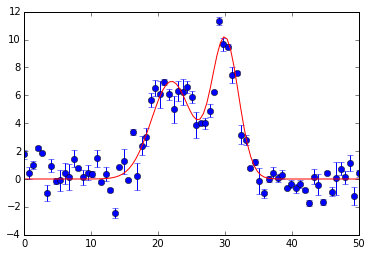

In [66]:
#read in data file
'''data=np.loadtxt('file.txt')
x=data[:,0]
y=data[:,1]
#if no errors then use mad in a line free vel range
e=np.empty(len(x))
e.fill(error_estimate(x,y,[73,85]))'''


# Generate fake data--single
np.random.seed(0)
X = np.linspace(0., 50., 75)
Y = oneDGauss(x,5,25,5,0)+np.random.randn(len(x))*0.5
E=np.random.randn(len(y))*0.5

# Generate fake data--double
np.random.seed(0)
X = np.linspace(0., 50., 75)
Y = oneDGauss_double(x,7,22,3,0,10,30,2,0)+np.random.randn(len(x))*1.
E=np.random.randn(len(y))*0.5

vels=np.linspace(0., 50., 100)

fig=plt.figure()
plt.errorbar(X,Y,yerr=E,ls='',marker='o')
#plt.plot(vels,oneDGauss(vels,5,25,5,0),color='r')
plt.plot(vels,oneDGauss_double(vels,7,22,3,0,10,30,2,0),color='r')

In [67]:
#single--amp,cen,std,offset
guess=[5,25,5,0]
fixp=[False,False,False,True]
ndim=4

#double--amp1,cen1,std1,offset1,amp2,cen2,std2,offset2
guess=[7,22,3,0,10,30,2,0]
fixp=[False,False,False,True,False,False,False,True]
ndim=8

line_name='line_test'
flag='double'

print 'number of dimensions is ',ndim
nwalkers = ndim*2
p0 = np.zeros((nwalkers,ndim))
for i in np.arange(ndim):
    if fixp[i]==True:
        p0[:,i]=guess[i]
    elif fixp[i]==False:
        p0[:,i]=(((np.random.randn(nwalkers))*0.01)+guess[i])
sampler = emcee.EnsembleSampler(nwalkers,ndim,lp,args=[X,Y,E,fixp,guess,flag],threads=1)

number of dimensions is  8


In [68]:
nBurn=200
with ProgressBar(nBurn,ipython_widget=True) as bar:
    for i,result in enumerate(sampler.sample(p0,iterations=nBurn)):
        bar.update()
pos,prob,state=result[0],result[1],result[2]

In [69]:
sampler.reset()
nSamp=500
with ProgressBar(nSamp,ipython_widget=True) as bar:
    for i,result in enumerate(sampler.sample(pos,iterations=nSamp)):
        bar.update()
pos,prob,state=result[0],result[1],result[2]

In [70]:
file_data='bestp_param_'+line_name+'_'+flag+'.txt'
bestp_file=open(file_data,'w')
for i in range(0,ndim):
    a=confidenceInterval(sampler.flatchain[:,i],1)
    bestp_file.write('{0} {1} {2}\n'.format(a[0],a[1],a[2]))
    print confidenceInterval(sampler.flatchain[:,i],1)
bestp_file.close()

[ 6.3194894   0.13294995  0.16751481]
[ 22.34571146   0.10770295   0.11154808]
[ 4.10404879  0.06173958  0.05524589]
[ 0.  0.  0.]
[ 9.50506256  0.24831766  0.22199738]
[  3.03747433e+01   2.83816074e-02   2.78487423e-02]
[ 1.5580299   0.02695564  0.03556967]
[ 0.  0.  0.]


In [71]:
filebp=np.loadtxt(file_data)
if flag=='single':
    amp=filebp[0][0]
    cen=filebp[1][0]
    sig=filebp[2][0]
    A=filebp[3][0]
elif flag=='double':
    amp1=filebp[0][0]
    cen1=filebp[1][0]
    sig1=filebp[2][0]
    A1=filebp[3][0]
    amp2=filebp[4][0]
    cen2=filebp[5][0]
    sig2=filebp[6][0]
    A2=filebp[7][0]


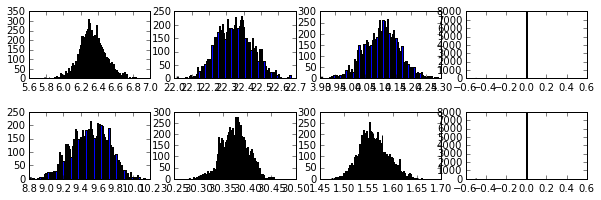

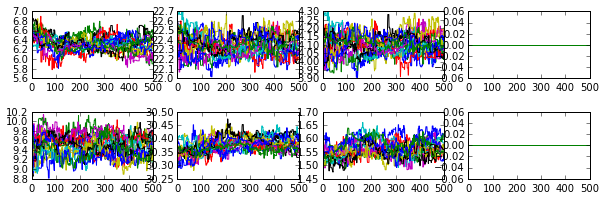

In [72]:

figa = plt.figure(figsize=(10,3))
if flag=='single':
    for i in range(0,ndim):
        plt.subplot(1,4,i+1)
        patches = plt.hist(sampler.flatchain[:,i],bins=100)
    figa.subplots_adjust(hspace=.5)
    figb = plt.figure(figsize=(10,3))
    for i in range(0,ndim):
        plt.subplot(1,4,i+1)
        plt.plot(sampler.chain[:,:,i].T)
    figb.subplots_adjust(hspace=.5)
elif flag=='double':
    for i in range(0,ndim):
        plt.subplot(2,4,i+1)
        patches = plt.hist(sampler.flatchain[:,i],bins=100)
    figa.subplots_adjust(hspace=.5)
    figb = plt.figure(figsize=(10,3))
    for i in range(0,ndim):
        plt.subplot(2,4,i+1)
        plt.plot(sampler.chain[:,:,i].T)
    figb.subplots_adjust(hspace=.5)

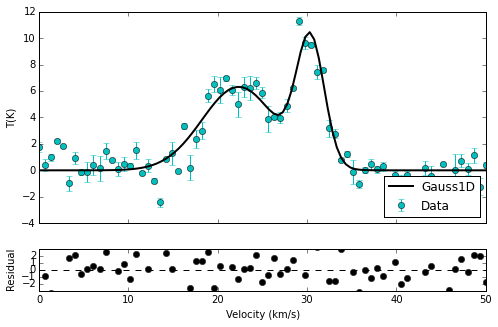

In [75]:
if flag=='single':
    #print amp,cen,sig,A
    gauss=oneDGauss(vels,amp,cen,sig,A)
elif flag=='double':
    #print amp1,cen1,sig1,A1,amp2,cen2,sig2,A2
    gauss=oneDGauss_double(vels,amp1,cen1,sig1,A1,amp2,cen2,sig2,A2)



fig,axes = plt.subplots(figsize=(8,5))
gs = gridspec.GridSpec(2, 1, height_ratios=[5, 1])
ax = plt.gca()
ax.set_rasterized(True)
ax1=plt.subplot(gs[0])
ax1.errorbar(X,Y,yerr=E,marker='o',ls='',label='Data',color='c')
ax1.plot(vels,gauss,color='k',marker='',ls='-',label='Gauss1D',lw=2)
ax1.set_ylabel('T(K)')
ax1.legend(loc='lower right',numpoints=1)
plt.setp(ax1.get_xticklabels(), visible=False)
ax2=plt.subplot(gs[1],sharex=ax1)
ax2.set_xlabel('Velocity (km/s)')
if flag=='single':
    ax2.plot(X,(Y-oneDGauss(X,amp,cen,sig,A))/E,marker='o',color='k',ls='')
elif flag=='double':
    ax2.plot(X,(Y-oneDGauss_double(X,amp1,cen1,sig1,A1,amp2,cen2,sig2,A2))/E,marker='o',color='k',ls='')
ax2.set_ylim(-3,3)
ax2.axhline(y=0,ls='--',color='k')
ax2.set_yticks([-2,-1,0,1,2])
ax2.set_ylabel('Residual')

In [74]:
if flag=='single':
    print 'Amp:',filebp[0][0], '-',filebp[0][1],'+',filebp[0][2], 'K'
    print 'Cen:',filebp[1][0], '-',filebp[1][1],'+',filebp[1][2], 'km/s'
    print 'Sig:',filebp[2][0], '-',filebp[2][1],'+',filebp[2][2], 'km/s'
    print 'FWHM:',2*np.sqrt(2*np.log(2))*filebp[2][0], '-',\
    2*np.sqrt(2*np.log(2))*filebp[2][1],'+',2*np.sqrt(2*np.log(2))*filebp[2][2], 'km/s'
    if filebp[3][0]!=0:
        print 'A:',filebp[3][0], '-',filebp[3][1],'+',filebp[3][2], 'K'
if flag=='double':
    print 'Amp1:',filebp[0][0], '-',filebp[0][1],'+',filebp[0][2], 'K'
    print 'Cen1:',filebp[1][0], '-',filebp[1][1],'+',filebp[1][2], 'km/s'
    print 'Sig1:',filebp[2][0], '-',filebp[2][1],'+',filebp[2][2], 'km/s'
    print 'FWHM1:',2*np.sqrt(2*np.log(2))*filebp[2][0], '-',\
    2*np.sqrt(2*np.log(2))*filebp[2][1],'+',2*np.sqrt(2*np.log(2))*filebp[2][2], 'km/s'
    if filebp[3][0]!=0:
        print 'A1:',filebp[3][0], '-',filebp[3][1],'+',filebp[3][2], 'K'
    print 'Amp2:',filebp[4][0], '-',filebp[4][1],'+',filebp[4][2], 'K'
    print 'Cen2:',filebp[5][0], '-',filebp[5][1],'+',filebp[5][2], 'km/s'
    print 'Sig2:',filebp[6][0], '-',filebp[6][1],'+',filebp[6][2], 'km/s'
    print 'FWHM2:',2*np.sqrt(2*np.log(2))*filebp[6][0], '-',\
    2*np.sqrt(2*np.log(2))*filebp[6][1],'+',2*np.sqrt(2*np.log(2))*filebp[6][2], 'km/s'
    if filebp[7][0]!=0:
        print 'A2:',filebp[7][0], '-',filebp[7][1],'+',filebp[7][2], 'K'

Amp1: 6.31948940296 - 0.132949946757 + 0.167514813142 K
Cen1: 22.3457114563 - 0.107702945854 + 0.111548078863 km/s
Sig1: 4.10404879079 - 0.0617395785664 + 0.0552458878114 km/s
FWHM1: 9.66429635834 - 0.14538559718 + 0.130094124024 km/s
Amp2: 9.50506255536 - 0.248317662799 + 0.221997384782 K
Cen2: 30.3747433188 - 0.028381607361 + 0.0278487422781 km/s
Sig2: 1.55802989545 - 0.0269556396092 + 0.0355696719815 km/s
FWHM2: 3.66888002856 - 0.0634756804784 + 0.0837601765772 km/s
